Applied from
https://keras.io/zh/examples/imdb_cnn/

Instead of using word embedding, it uses character encoding.



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd drive/My\ Drive/Colab\ Notebooks/data/imdb-kaggle/

In [23]:
from __future__ import print_function

import keras

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.optimizers import Adam

import pandas as pd
import numpy as np

import string

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns

import matplotlib.pyplot as plt

In [24]:
data_path = 'IMDB_Dataset.csv'
df = pd.read_csv(data_path)
df = df[['review', 'sentiment']]
df = df.sample(frac=1)

In [25]:
feature_column = 'sentiment'
x_column = 'review'

train_percent = 0.90 # 90%
val_percent = 0.98   # 8%
test_percent = 1.00  # 2%

text = []
classes = []
classes_count = {}

for index, row in df.iterrows():
    text.append(row[x_column])
    classes_ = row[feature_column]
    classes_ = classes_.split(', ')
    if len(classes_) > 1:
        for class_ in classes_:
            if class_ not in classes:
                classes.append(class_)
                classes_count[class_] = 1
            else:
                classes_count[class_] += 1

    else:
        if classes_[0] not in classes:
            classes.append(classes_[0])
            classes_count[classes_[0]] = 1
        else:
            classes_count[classes_[0]] += 1


print(classes)
num_class = len(classes)
print(num_class)

y = []
for index, row in df.iterrows():
    classes_ = row[feature_column]
    classes_ = classes_.split(', ')
    feature = np.zeros((num_class, 1))
    if len(classes_) > 1:
        for class_ in classes_:
            feature[classes.index(class_)]=1
    else:
        feature[classes.index(classes_[0])]=1
    y.append(feature)


vocab = sorted(set(string.ascii_lowercase) | 
                {' ',',','.'} |
                {'0','1','2','3','4','5','6','7','8','9'}
)

print(vocab)
print ('{} unique characters'.format(len(vocab)))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
print("idx2char", idx2char)


['negative', 'positive']
2
[' ', ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
39 unique characters
idx2char [' ' ',' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e'
 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w'
 'x' 'y' 'z']


In [26]:
import re
# from
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [27]:
x = []
for text_ in text:
    t = ''
    text_ = remove_html_tags(text_.lower())
    for c in text_:
      if c in idx2char:
        t += c
    x.append(np.array([char2idx[c] for c in t]))


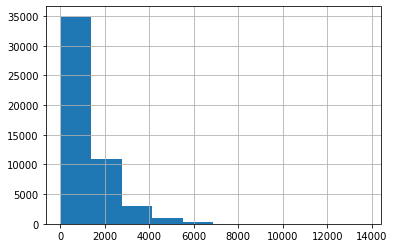

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
dtype: float64

In [28]:
sentences_len = [len(x) for x in text]
pd.Series(sentences_len).hist()
plt.show()
pd.Series(sentences_len).describe()

In [29]:

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []
o_test = [] # original text before mapping
data_num = len(x)
maxlen = 2500 # about 2 times mean of number of characters

for i in range(data_num):
    if len(x[i]) > maxlen:
      x[i] = x[i][:maxlen]
    if (i/data_num) < train_percent:
        x_ = np.zeros((maxlen))
        x_[:len(x[i])]=x[i]
        x_train.append(x_)
        y_train.append(y[i])
    elif (i/data_num) < val_percent:
        x_ = np.zeros((maxlen))
        x_[:len(x[i])]=x[i]
        x_val.append(x_)
        y_val.append(y[i])
    else:
        x_ = np.zeros((maxlen))
        x_[:len(x[i])]=x[i]
        x_test.append(x_)
        y_test.append(y[i])
        o_test.append(text[i])

x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)
x_test = np.stack(x_test)
y_test = np.stack(y_test)

n_features = 1
x_train = x_train.reshape((-1, maxlen, n_features))
y_train = y_train.reshape((-1, num_class))
x_val = x_val.reshape((-1, maxlen, n_features))
y_val = y_val.reshape((-1, num_class))
x_test = x_test.reshape((-1, maxlen, n_features))
y_test = y_test.reshape((-1, num_class))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

print('shape', x_test.shape)


Pad sequences (samples x time)
x_train shape: (45000, 2500, 1)
x_val shape: (4000, 2500, 1)
x_test shape: (1000, 2500, 1)
shape (1000, 2500, 1)


In [30]:
x_train[:2]

array([[[21],
        [26],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[13],
        [30],
        [25],
        ...,
        [ 0],
        [ 0],
        [ 0]]], dtype=int32)

In [31]:

model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, 
                activation='relu', 
                input_shape=(maxlen,n_features)))
model.add(Conv1D(filters=128, kernel_size=3, 
                activation='relu'))
model.add(Dropout(0.2))

model.add(GlobalMaxPooling1D())

model.add(Dense(num_class))
model.add(Activation('softmax'))

opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', keras.metrics.AUC()])
history = model.fit(x_train, y_train,
          batch_size=8,
          epochs=20,
          validation_data=(x_val, y_val))


Epoch 1/20
5625/5625 [==============================] - 33s 6ms/step - loss: 0.7098 - accuracy: 0.5388 - auc_1: 0.5513 - val_loss: 0.6812 - val_accuracy: 0.5683 - val_auc_1: 0.5879
Epoch 2/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.6676 - accuracy: 0.5873 - auc_1: 0.6252 - val_loss: 0.6877 - val_accuracy: 0.5420 - val_auc_1: 0.6112
Epoch 3/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.6355 - accuracy: 0.6358 - auc_1: 0.6894 - val_loss: 0.6221 - val_accuracy: 0.6500 - val_auc_1: 0.7098
Epoch 4/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.6216 - accuracy: 0.6533 - auc_1: 0.7105 - val_loss: 0.6047 - val_accuracy: 0.6745 - val_auc_1: 0.7365
Epoch 5/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.6131 - accuracy: 0.6608 - auc_1: 0.7212 - val_loss: 0.5967 - val_accuracy: 0.6885 - val_auc_1: 0.7504
Epoch 6/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.6026 - accuracy:

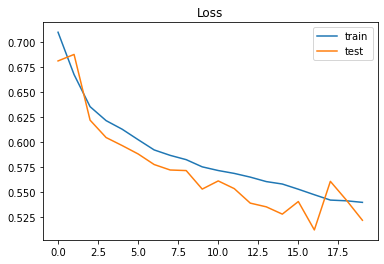

In [32]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

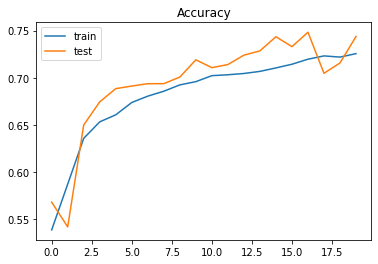

In [33]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

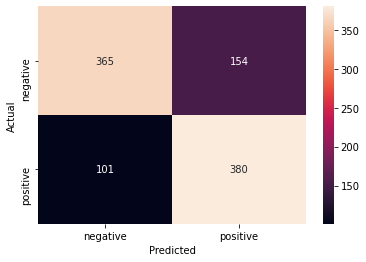

In [34]:
probs = model.predict(x_test)
probs_df = pd.DataFrame(probs)
preds = probs_df.idxmax(axis=1)
acts = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(acts, preds)

sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [35]:
probs[:][:][1]

array([0.34776577, 0.6522342 ], dtype=float32)

In [36]:
results = pd.DataFrame(columns=['text', 'predict', 'actual', 'score'])
results['text'] = o_test
results['predict'] = list(preds)
results['actual'] = list(acts)
results['score'] = list(probs)

print(classes)
results

['negative', 'positive']


,text,predict,actual,score
0,The director and two stars of LAURA (1944) wer...,0,1,"[0.62250656, 0.3774935]"
1,Preston Sturgis' THE POWER AND THE GLORY was u...,1,1,"[0.34776577, 0.6522342]"
2,"Time travel is theoretical, so I can give the ...",0,0,"[0.7777648, 0.22223517]"
3,This is just a long advertisement for the movi...,0,0,"[0.61468244, 0.3853176]"
4,One piece of trivia that is often forgotten ab...,0,1,"[0.6710618, 0.32893822]"
...,...,...,...,...
995,Barney is just awful. As many of the other rev...,0,0,"[0.55674976, 0.44325024]"
996,"This is a strange, little, forgotten movie fro...",1,1,"[0.3171864, 0.6828136]"
997,"Beautifully filmed, well acted, tightly script...",1,1,"[0.17540689, 0.8245931]"
998,"I loved the first 15 minutes, and I loved some...",1,0,"[0.16697319, 0.83302677]"


In [37]:
incorrects = results[:][results['predict'] != results['actual']]

In [38]:
for idx in range(10):
  print(idx+1)
  print(incorrects.iloc[idx]['text'])
  print('predict:', classes[incorrects.iloc[idx]['predict']], '(', int(incorrects.iloc[idx]['score'][incorrects.iloc[idx]['predict']]*100), '%)')
  print('actual:', classes[incorrects.iloc[idx]['actual']])
  print()

1
The director and two stars of LAURA (1944) were reteamed for this solid policier: Dana Andrews is the son of a criminal who becomes a cop to cut all ties with the past but cannot keep his inherited violent ways in check while interrogating suspects and, one night, he goes too far; Gene Tierney is the estranged wife of his victim, a decorated war hero who has become involved with the town's leading racketeer and Andrews' No. 1 nemesis, Gary Merrill (who had himself been the protégé of Andrews Snr.)! As usual with Preminger, this is a well-crafted movie with a notable opening credits sequence and enlivened by a good cast that also includes Karl Malden (as Andrews' incumbent superior), Tom Tully (as Tierney's motor-mouth taxi driver dad) and Neville Brand (as Merrill's chief thug), with notable support also coming from Craig Stevens (as the slimy, wife-beating victim), Bert Freed (as Andrews' sympathetic partner) and Robert F. Nolan (as Andrews' stern outgoing superior). Having already 

In [39]:
corrects = results[:][results['predict'] == results['actual']]

In [40]:
for idx in range(10):
  print(idx+1)
  print(corrects.iloc[idx]['text'])
  print('predict:', classes[corrects.iloc[idx]['predict']], '(', int(corrects.iloc[idx]['score'][corrects.iloc[idx]['predict']]*100), '%)')
  print('actual:', classes[corrects.iloc[idx]['actual']])
  print()

1
Preston Sturgis' THE POWER AND THE GLORY was unseen by the public for nearly twenty or thirty years until the late 1990s when it resurfaced and even showed up on television. In the meantime it had gained in notoriety because Pauline Kael's THE CITIZEN KANE BOOK had suggested that the Herman Mankiewicz - Orson Welles screenplay for KANE was based on Sturgis' screenplay here. As is mentioned in the beginning of this thread for the film on the IMDb web site, Kael overstated her case.<br /><br />There are about six narrators who take turns dealing with the life of Charles Foster Kane: the newsreel (representing Ralston - the Henry Luce clone), Thatcher's memoirs, Bernstein, Jed Leland, Susan Alexander Kane, and Raymond the butler. Each has his or her different slant on Kane, reflecting their faith or disappointment or hatred of the man. And of course each also reveals his or her own failings when they are telling their version of Kane's story. This method also leads to frequent overlappi